# Fallen Angels: The Best of High Yield or The Worst of Investment Grade

This notebook will look at Fallen Angels to try and understand what kind of asset they are since they can be thought of as both investment grade, high yield, or a mix of both. There are arguments for both sides while neither of them reject that the risk premia exists. 

To keep things applicable the following ETFs will be used <br>
1. ANGL
2. LQD
3. JNK

## Packages

In [1]:
import sys
import numpy as np
import pandas as pd
import statsmodels.api as sm

import matplotlib.pyplot as plt
from   matplotlib.ticker import FuncFormatter

## Get Data

In [2]:
sys.path.append(r"C:\Users\Diego\Desktop\app_prod\research\FallenAngel\root\src")
from DataCollect import DataCollect

In [3]:
def get_data(ig_tickers = ['ANGL', 'LQD', 'JNK']) -> pd.DataFrame:

    df_px = (DataCollect().get_raw_px().query(
        "security == @ig_tickers").
        assign(date = lambda x: pd.to_datetime(x.date)))

    df_fund = (DataCollect().clean_bond_fundamentals().query(
        "security == @ig_tickers").
        pivot(index = ["date", "security"], columns = "variable", values = "value"))

    df_combined = (df_fund.merge(
        right = df_px, how = "outer", on = ["date", "security"]))
    
    return df_combined

df = get_data()


## Historical Returns

In [4]:
def _get_rtn(df: pd.DataFrame) -> pd.DataFrame: 
    
    df_out = (df[
        ["date", "security", "MOD_DUR", "PX"]].
        sort_values("date").
        dropna().
        assign(
            px_rtn = lambda x: x.PX.pct_change(),
            px_bps = lambda x: x.PX.diff() / x.MOD_DUR))
    
    return df_out

def get_rtn(df: pd.DataFrame) -> pd.DataFrame:

    df_out = (df.groupby(
        "security").
        apply(_get_rtn).
        reset_index(drop = True))
    
    return df_out

df_rtn = get_rtn(df)

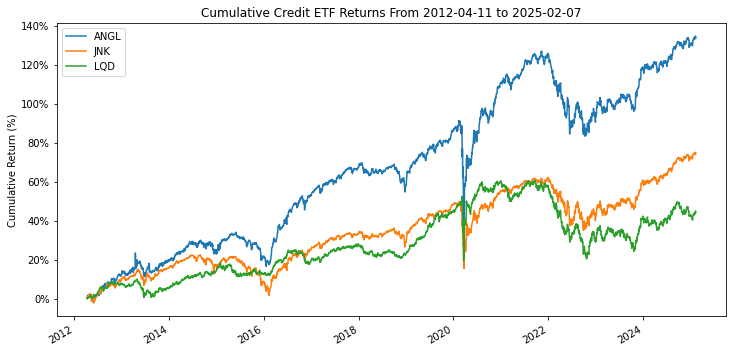

In [5]:
def plot_cumulative_rtn(df: pd.DataFrame) -> plt.Figure: 
    
    fig, axes = plt.subplots(figsize = (12,6))

    df_wider = (df.rename(
        columns = {"security": ""}).
        pivot(index = "date", columns = "", values = "PX").
        dropna().
        pct_change())

    (df_wider.apply(
        lambda x: np.cumprod(1 + x) - 1).
        plot(
            ylabel = "Cumulative Return (%)",
            ax     = axes,
            xlabel = "",
            title  = "Cumulative Credit ETF Returns From {} to {}".format(
                df_wider.index.min().date(),
                df_wider.index.max().date())))

    axes.yaxis.set_major_formatter(FuncFormatter(lambda y, _: f'{y * 100:.0f}%'))
    
plot_cumulative_rtn(df)

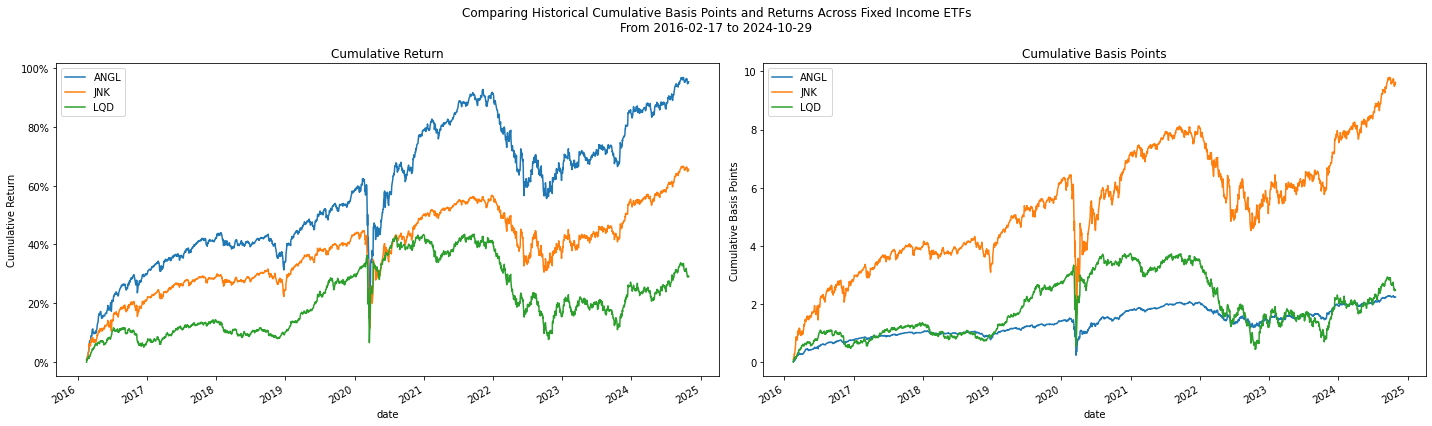

In [6]:
def plot_return(df_rtn: pd.DataFrame) -> plt.Figure:
    
    df_tmp = (df_rtn.drop(
        columns = ["MOD_DUR", "PX"]).
        melt(id_vars = ["date", "security"]))

    renamer = {
        "px_bps": "Cumulative Basis Points",
        "px_rtn": "Cumulative Return"}

    variables = df_tmp.variable.drop_duplicates().sort_values(ascending = False).to_list()
    fig, axes = plt.subplots(ncols = len(variables), figsize = (len(variables) * 10, 6))

    for variable, ax in zip(variables, axes.flatten()):

        df_wider = (df_tmp.query(
            "variable == @variable").
            rename(columns = {"security": ""}).
            pivot(index = "date", columns = "", values = "value").
            dropna())

        if variable == "px_rtn": 
            df_cum = np.cumprod(1 + df_wider) - 1
            ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: f'{y * 100:.0f}%'))

        else: 
            df_cum = df_wider.cumsum()

        df_cum.plot(
            ax     = ax,
            title  = renamer[variable],
            ylabel = renamer[variable])

    fig.suptitle("Comparing Historical Cumulative Basis Points and Returns Across Fixed Income ETFs\nFrom {} to {}".format(
        df_wider.index.min().date(),
        df_wider.index.max().date()))

    plt.tight_layout()
    
plot_return(df_rtn)

Since at only this time its only known that fallen angels should bare more credit risk than investment grade bonds, but unsure whether or not they bare more risk than high yield - at this time start by measure the excess duration netural returns of fallen angels and high yield after accounting for investment grade return.

In [7]:
def _get_excess_rtn(df: pd.DataFrame) -> pd.DataFrame: 
    
    df_rtn = (df[
        ["date", "LQD-PX", "security", "variable", "value"]].
        query("variable == 'PX'").
        pivot(index = ["date", "LQD-PX"], columns = "security", values = "value").
        reset_index().
        set_index("date").
        rename(columns = {"LQD-PX": "LQD"}).
        pct_change().
        reset_index().
        melt(id_vars = "date").
        rename(columns = {"value": "px_rtn"}))
    
    df_dur = (df[
        ["date", "LQD-MOD_DUR", "security", "variable", "value"]].
        query("variable == 'MOD_DUR'").
        pivot(index = ["date", "LQD-MOD_DUR"], columns = "security", values = "value").
        reset_index().
        set_index("date").
        rename(columns = {"LQD-MOD_DUR": "LQD"}))
    
    df_out = (df_dur.apply(
        lambda x: 1/x).
        assign(cum_val = lambda x: x.sum(axis = 1)).
        shift().
        reset_index().
        melt(id_vars = ["date", "cum_val"]).
        merge(right = df_rtn, how = "inner", on = ["date", "security"]).
        dropna().
        assign(weighted_rtn = lambda x: x.px_rtn * x.value).
        pivot(index = "date", columns = "security", values = "weighted_rtn").
        assign(spread = lambda x: x[df.name] - x.LQD ).
        reset_index().
        melt(id_vars = ["date", "spread"]).
        drop(columns = ["security", "value"]).
        drop_duplicates())

    
    return df_out
    
def get_excess_ig_rtn(df: pd.DataFrame) -> pd.DataFrame: 

    df_out = (df.drop(
        columns = ["ISPREAD", "YAS", "YLD"]).
        melt(id_vars = ["date", "security"]).
        assign(group_var = lambda x: x.security + "-" + x.variable).
        pivot(index = "date", columns = "group_var", values = "value").
        reset_index().
        melt(id_vars = ["date", "LQD-MOD_DUR", "LQD-PX"]).
        dropna().
        assign(
            security = lambda x: x.group_var.str.split("-").str[0],
            variable = lambda x: x.group_var.str.split("-").str[1]).
        groupby("security").
        apply(_get_excess_rtn).
        reset_index().
        drop(columns = ["level_1"]))
    
    return df_out

df_ig_excess = get_excess_ig_rtn(df)

In [8]:
def ig_vol_excess(df: pd.DataFrame) -> pd.DataFrame: 
    
    df_px_rtn = (df.pivot(
        index = "date", columns = "security", values = "PX").
        pct_change().
        dropna())

    df_out     = pd.DataFrame()
    ig_tickers = ["ANGL", "JNK"]

    for ticker in ig_tickers:

        df_tmp = (df_px_rtn[
            ["LQD", ticker]])

        df_vol = (df_tmp.ewm(
            span = 30, adjust = False).
            std().
            shift().
            apply(lambda x: 1 / x).
            dropna().
            assign(cum_val = lambda x: x.sum(axis = 1)).
            reset_index().
            melt(id_vars = ["date", "cum_val"]).
            assign(weight = lambda x: x.value / x.cum_val)
            [["date", "security", "weight"]])

        df_tmp_rtn = (df_tmp.reset_index().melt(
            id_vars = "date").
            rename(columns = {"value": "rtn"}).
            merge(right = df_vol, how = "inner", on = ["date", "security"]).
            assign(weighted_rtn = lambda x: x.rtn * x.weight).
            pivot(index = "date", columns = "security", values = "weighted_rtn").
            assign(
                ticker = ticker,
                spread = lambda x: x[ticker] - x.LQD).
            reset_index()
            [["date", "spread", "ticker"]].
            rename(columns = {"ticker": "security"}))

        df_out = pd.concat([df_out, df_tmp_rtn])
        
    return df_out

df_vol_excess = ig_vol_excess(df)

In [9]:
def get_spread(df_ig_exess: pd.DataFrame, df_vol_excess: pd.DataFrame) -> pd.DataFrame:
    
    df_dur = (df_ig_excess.rename(
        columns = {"spread": "dur_excess"}))

    df_vol = (df_vol_excess.rename(
        columns = {"spread": "vol_neutral"}))

    df_out = (df_dur.merge(
        right = df_vol, how = "inner", on = ["date", "security"]).
        melt(id_vars = ["security", "date"]).
        pivot(index = ["date", "variable"], columns = "security", values = "value").
        dropna().
        reset_index())
    
    return df_out

df_rtn_spread = get_spread(df_ig_excess, df_vol_excess)

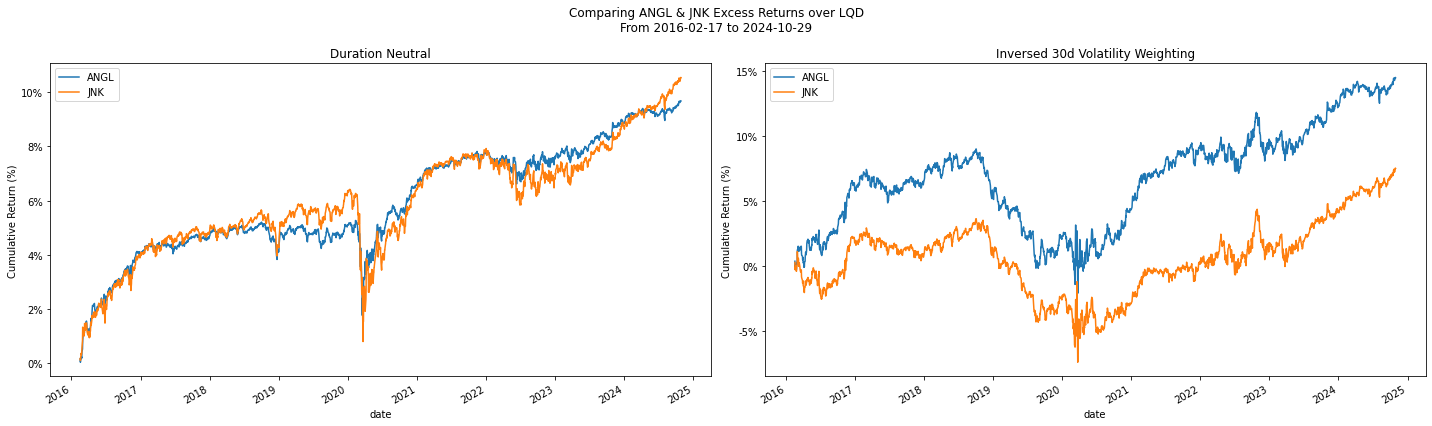

In [10]:
def plot_ig_excess_rtn(df_rtn_spread: pd.DataFrame) -> plt.Figure: 
    
    renamer = {
        "dur_excess" : "Duration Neutral",
        "vol_neutral": "Inversed 30d Volatility Weighting"}

    variables = df_rtn_spread.variable.drop_duplicates().sort_values().to_list()
    fig, axes = plt.subplots(ncols = len(variables), figsize = (20,6))

    for variable, ax in zip(variables, axes.flatten()):

        (df_rtn_spread.query(
            "variable == @variable").
            drop(columns = ["variable"]).
            melt(id_vars = "date").
            rename(columns = {"security": ""}).
            pivot(index = "date", columns = "", values = "value").
            apply(lambda x: np.cumprod(1 + x) - 1).
            plot(
                ax     = ax,
                title  = renamer[variable],
                ylabel = "Cumulative Return (%)"))

        ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: f'{y * 100:.0f}%'))

    fig.suptitle("Comparing ANGL & JNK Excess Returns over LQD\nFrom {} to {}".format(
        df_rtn_spread.date.min().date(),
        df_rtn_spread.date.max().date()))

    plt.tight_layout()
    
plot_ig_excess_rtn(df_rtn_spread)

In [11]:
def get_sharpe(df_rtn: pd.DataFrame) -> pd.DataFrame: 
    
    df_sharpe = (df_rtn.drop(
        columns = ["MOD_DUR", "PX"]).
        melt(id_vars = ["date", "security"]).
        drop(columns = ["date"]).
        groupby(["security", "variable"]).
        agg(["mean", "std"])
        ["value"].
        rename(columns = {
            "mean": "mean_rtn",
            "std" : "std_rtn"}).
        assign(sharpe = lambda x: x.mean_rtn / x.std_rtn * np.sqrt(252)).
        reset_index())
    
    return df_sharpe

df_sharpe = get_sharpe(df_rtn)

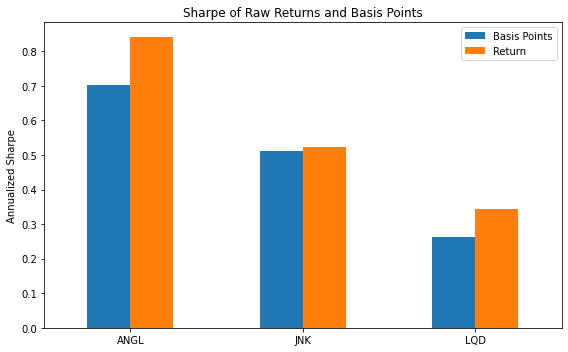

In [12]:
def get_sharpe(df_sharpe: pd.DataFrame) -> plt.Figure: 
    
    renamer = {
        "px_bps": "Basis Points",
        "px_rtn": "Return"}

    (df_sharpe.rename(
        columns = {"variable": ""}).
        pivot(index = "security", columns = "", values = "sharpe").
        rename(columns = renamer).
        plot(
            kind    = "bar",
            rot     = 0,
            xlabel  = "",
            ylabel  = "Annualized Sharpe",
            figsize = (8,5),
            title   = "Sharpe of Raw Returns and Basis Points"))

    plt.tight_layout()
    
get_sharpe(df_sharpe)

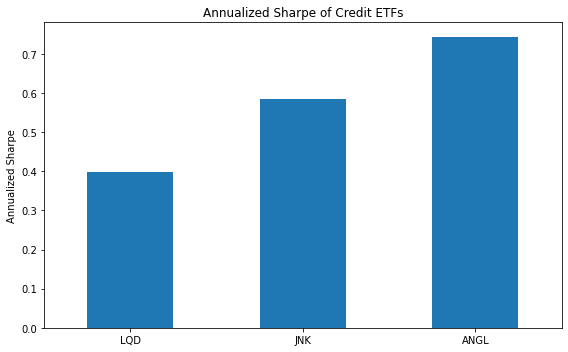

In [37]:
def plot_sharpes(df: pd.DataFrame) -> plt.Figure: 
    
    (df.pivot(
        index = "date", columns = "security", values = "PX").
        dropna().
        pct_change().
        reset_index().
        melt(id_vars = "date").
        drop(columns = ["date"]).
        groupby("security").
        agg(["mean", "std"])
        ["value"].
        rename(columns = {
            "mean": "mean_rtn",
            "std" : "std_rtn"}).
        assign(sharpe = lambda x: x.mean_rtn / x.std_rtn * np.sqrt(252))
        [["sharpe"]].
        sort_values("sharpe").
        plot(
            rot     = 0,
            kind    = "bar",
            legend  = False,
            title   = "Annualized Sharpe of Credit ETFs",
            ylabel  = "Annualized Sharpe",
            xlabel  = "",
            figsize = (8,5)))
    
    plt.tight_layout()
    
plot_sharpes(df)

## Returns Comparison

In [13]:
def get_comparison(df_rtn: pd.DataFrame) -> pd.DataFrame: 
    
    df_out = (df_rtn.drop(
        columns = ["PX", "MOD_DUR"]).
        melt(id_vars = ["date", "security"]).
        pivot(index = ["date", "variable"], columns = "security", values = "value").
        reset_index().
        rename(columns = {"variable": "rtn_group"}).
        melt(id_vars = ["date", "rtn_group", "ANGL"]).
        dropna())
    
    return df_out

df_compare = get_comparison(df_rtn)

In [14]:
def get_corr(df_compare: pd.DataFrame) -> pd.DataFrame: 
    
    df_corr = (df_compare.drop(
        columns = ["date"]).
        groupby(["rtn_group", "security"]).
        agg("corr").
        drop(columns = ["value"]).
        query("ANGL != 1").
        reset_index().
        drop(columns = ["level_2"]))
    
    return df_corr

df_corr = get_corr(df_compare)

In [15]:
def _get_ols(df: pd.DataFrame) -> pd.DataFrame:
    
    model = (sm.OLS(
        endog = df.ANGL,
        exog  = sm.add_constant(df.value)).
        fit())
    
    df_val = (model.params.to_frame(
        name = "val").
        reset_index())
    
    return df_val

def get_beta(df_compare: pd.DataFrame) -> pd.DataFrame: 

    df_beta = (df_compare.groupby(
        ["rtn_group", "security"]).
        apply(_get_ols).
        reset_index().
        drop(columns = ["level_2"]).
        query("index == 'value'"))
    
    return df_beta

df_beta = get_beta(df_compare)

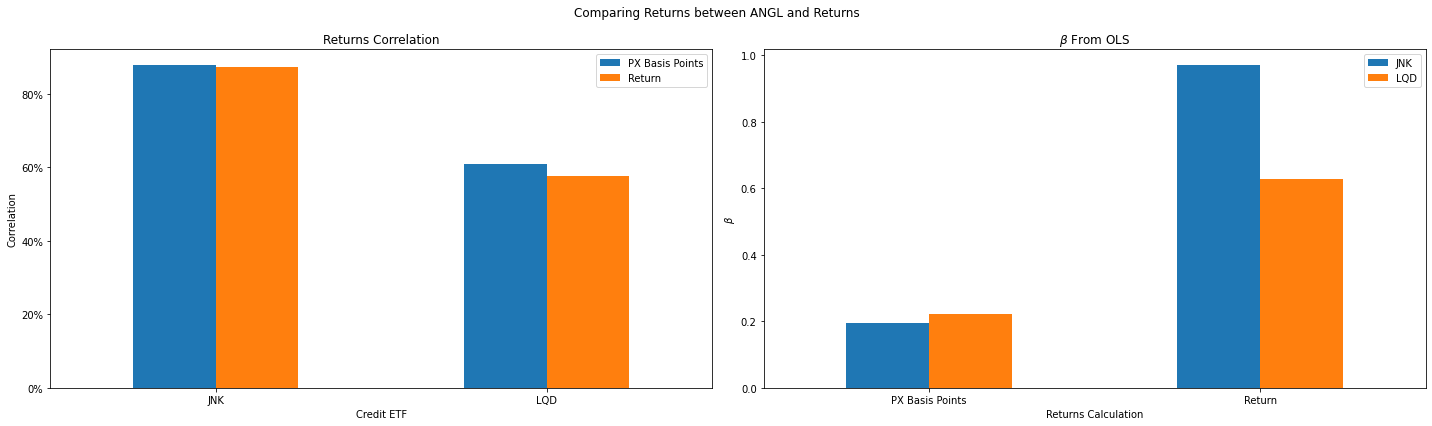

In [16]:
def plot_comparison(df_beta: pd.DataFrame, df_corr: pd.DataFrame) -> plt.Figure:
    
    fig, axes = plt.subplots(ncols = 2, figsize = (20,6))

    rtn_replacer = {
        "px_bps": "PX Basis Points",
        "px_rtn": "Return"}

    (df_corr.rename(
        columns = {"rtn_group": ""}).
        pivot(index = "security", columns = "", values = "ANGL").
        rename(columns = rtn_replacer).
        plot(
            kind   = "bar",
            ax     = axes[0],
            xlabel = "Credit ETF",
            rot    = 0,
            ylabel = "Correlation",
            title  = "Returns Correlation"))

    (df_beta.rename(
        columns = {"security": ""}).
        replace(rtn_replacer).
        pivot(index = "rtn_group", columns = "", values = "val").
        plot(
            kind   = "bar",
            ax     = axes[1],
            xlabel = "Returns Calculation",
            rot    = 0,
            ylabel = r"$\beta$",
            title  = r"$\beta$ From OLS"))

    axes[0].yaxis.set_major_formatter(FuncFormatter(lambda y, _: f'{y * 100:.0f}%'))
    fig.suptitle("Comparing Returns between ANGL and Returns")
    plt.tight_layout()
    
plot_comparison(df_beta, df_corr)

## Yield Comparison

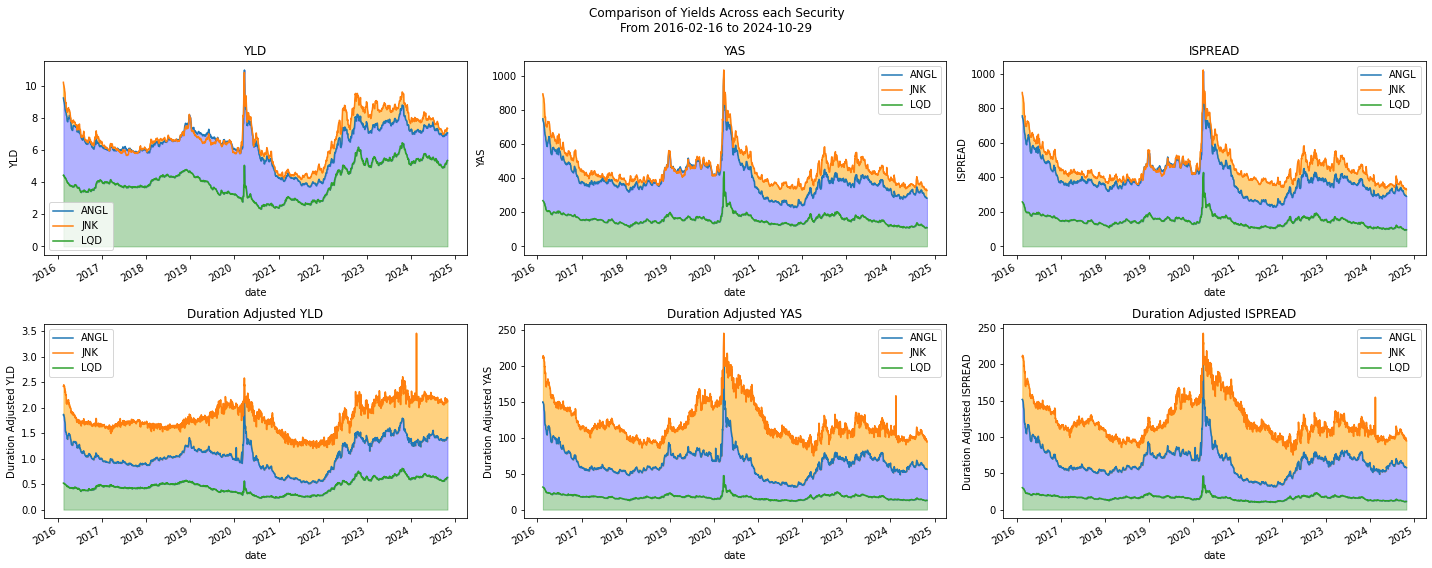

In [17]:
def plot_yield_spread(df: pd.DataFrame) -> plt.Figure: 
    
    df_prep = (df.drop(
        columns = ["PX"]).
        melt(id_vars = ["date", "security", "MOD_DUR"]).
        assign(adj_val = lambda x: x.value / x.MOD_DUR).
        rename(columns = {"adj_val": "Duration Adjusted"}).
        drop(columns = ["MOD_DUR"]).
        rename(columns = {
            "variable": "yield_var",
            "value"   : ""}).
        melt(id_vars = ["date", "security", "yield_var"]).
        assign(group_var = lambda x: x.variable + " " + x.yield_var).
        assign(group_var = lambda x: x.group_var.str.strip()))

    variables = df_prep.group_var.drop_duplicates().sort_values(ascending = False).to_list()
    fig, axes = plt.subplots(ncols = len(variables) // 2, nrows = len(variables) // 3, figsize = (20,8))

    for variable, ax in zip(variables, axes.flatten()): 

        df_plot = (df_prep.query(
            "group_var == @variable").
            rename(columns = {"security": ""}).
            pivot(index = "date", columns = "", values = "value").
            dropna())
        
        (df_plot.plot(
            ax     = ax,
            legend = True,
            ylabel = variable,
            title  = variable))
        
        ax.fill_between(
            x     = df_plot.index,
            y1    = 0,
            y2    = df_plot.LQD, 
            where = 0 < df_plot.LQD,
            color = "green",
            alpha = 0.3)

        ax.fill_between(
            x     = df_plot.index,
            y1    = df_plot.LQD,
            y2    = df_plot.ANGL, 
            where = df_plot.LQD < df_plot.ANGL,
            color = "blue",
            alpha = 0.3)

        ax.fill_between(
            x     = df_plot.index,
            y1    = df_plot.ANGL,
            y2    = df_plot.JNK,
            where = df_plot.ANGL < df_plot.JNK,
            color = "orange",
            alpha = 0.5)

    fig.suptitle("Comparison of Yields Across each Security\nFrom {} to {}".format(
        df_plot.index.min().date(),
        df_plot.index.max().date()))
    
    plt.tight_layout()
    
plot_yield_spread(df)

In [18]:
def _get_corr(df: pd.DataFrame) -> pd.DataFrame: 
    
    df_out = (df.drop(
        columns = ["yield_var", "variable"]).
        pivot(index = ["date", "ANGL"], columns = "security", values = "value").
        reset_index().
        set_index("date").
        apply(lambda x: np.log(x)).
        diff().
        corr().
        reset_index().
        rename(columns = {"security": "sec1"}).
        melt(id_vars = "sec1").
        query("sec1 == 'ANGL' & security != 'ANGL'"))
    
    return df_out

def get_yld_corr(df: pd.DataFrame) -> pd.DataFrame: 
    
    df_prep = (df.drop(
        columns = ["PX"]).
        melt(id_vars = ["date", "security", "MOD_DUR"]).
        assign(adj_val = lambda x: x.value / x.MOD_DUR).
        rename(columns = {"adj_val": "Duration Adjusted"}).
        drop(columns = ["MOD_DUR"]).
        rename(columns = {
            "variable": "yield_var",
            "value"   : ""}).
        melt(id_vars = ["date", "security", "yield_var"]).
        assign(group_var = lambda x: x.variable + " " + x.yield_var).
        assign(group_var = lambda x: x.group_var.str.strip()).
        drop(columns = ["group_var"]))

    df_corr = (df_prep.pivot(
        index = ["date", "yield_var", "variable"], columns = "security", values = "value").
        reset_index().
        melt(id_vars = ["date", "yield_var", "variable", "ANGL"]).
        dropna().
        groupby(["yield_var", "variable"]).
        apply(_get_corr).
        reset_index().
        drop(columns = ["level_2", "sec1"]))
    
    return df_corr

df_yld_corr = get_yld_corr(df)

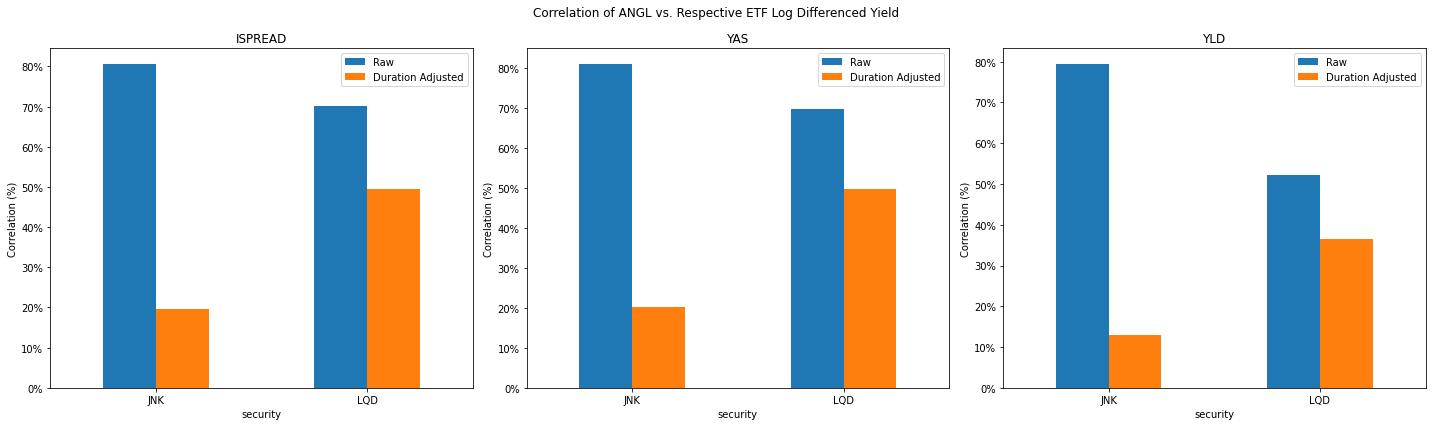

In [19]:
def plot_yield_correlation(df_yld_corr: pd.DataFrame) -> plt.Figure: 
    
    variables = df_yld_corr.yield_var.drop_duplicates().sort_values().to_list()
    fig, axes = plt.subplots(ncols = len(variables), figsize = (20,6))

    for variable, ax in zip(variables, axes.flatten()):

        (df_yld_corr.query(
            "yield_var == @variable").
            rename(columns = {"variable": ""}).
            pivot(index = "security", columns = "", values = "value").
            rename(columns = {"": "Raw"}).
            plot(
                kind   = "bar",
                title  = variable,
                ax     = ax,
                ylabel = "Correlation (%)",
                rot    = 0))
        
        ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: f'{y * 100:.0f}%'))

    fig.suptitle("Correlation of ANGL vs. Respective ETF Log Differenced Yield")
    plt.tight_layout()
    
plot_yield_correlation(df_yld_corr)

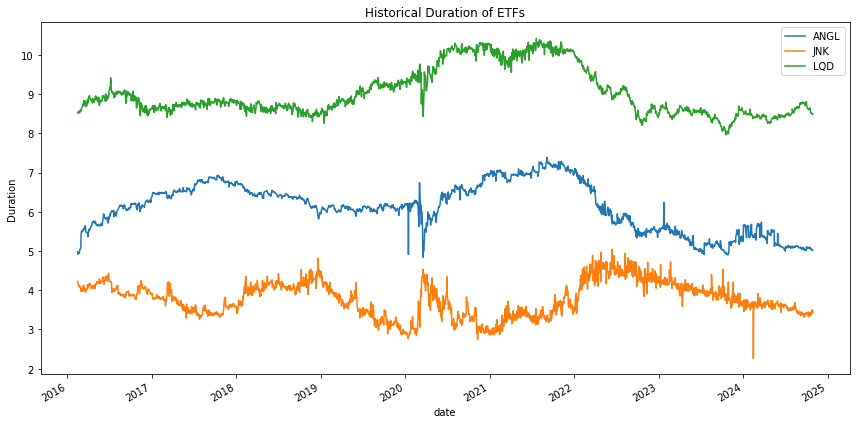

In [20]:
def plot_duration(df: pd.DataFrame) -> plt.Figure: 
    
    (df.rename(
        columns = {"security": ""}).
        pivot(index = "date", columns = "", values = "MOD_DUR").
        dropna().
        plot(
            title   = "Historical Duration of ETFs",
            ylabel  = "Duration",
            figsize = (12,6)))
    
    plt.tight_layout()
    
plot_duration(df)